In [2]:
import os.path
import numpy as np
import pickle
import xgboost as xgb
from bayes_opt import BayesianOptimization
from sklearn import metrics
import pandas as pd


def mean_absolute_percentage_error(y_true, y_pred): 

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mean_absolute_range_percentage_error(y_true, y_pred): 
    error = np.abs((y_val- y_pred))-10000
    error[error < 0] = 0
    return np.mean(error/y_true)*100

path = os.getcwd()

with open(path + '/data/OHE_uk.pkl', 'rb') as file:
    OHE_train,OHE_val,OHE_test,feature_names_OHE = pickle.load(file)
with open(path + '/data/TFIDF_uk.pkl', 'rb') as file:
    TFIDF_train,TFIDF_val,TFIDF_test,feature_names_TFIDF = pickle.load(file)
with open(path + '/data/BOG_uk.pkl', 'rb') as file:
    BOG_train,BOG_val,BOG_test,feature_names_BOG = pickle.load(file)
with open(path + '/data/TECH_uk.pkl', 'rb') as file:    
    TECH_train,TECH_val,TECH_test,feature_names_TECH = pickle.load(file)
with open(path + '/data/yTrainValTest_uk.pkl', 'rb') as file:
        y_train,y_val,y_test= pickle.load(file) 



X_train = pd.DataFrame(np.hstack((OHE_train,TFIDF_train)), columns = list(feature_names_OHE)+list(feature_names_TFIDF))
X_val = pd.DataFrame(np.hstack((OHE_val,TFIDF_val)), columns =list(feature_names_OHE)+list(feature_names_TFIDF))
X_test = pd.DataFrame(np.hstack((OHE_test,TFIDF_test)), columns = list(feature_names_OHE)+list(feature_names_TFIDF))


#remove 'company' variables
cols = [c for c in X_train.columns if 'company_' not in c]

X_train = X_train[cols]
X_val = X_val[cols]
X_test = X_test[cols]
feature_names = cols


params = {
    # Learning Task Parameters
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',  # Evaluation metrics for validation data
    # Parameters for Tree Booster
    'learning_rate': 0.05,  # Learning Rate: step size shrinkage used to prevent overfitting.
    # Paramters for XGB ScikitLearn API
    'n_jobs': -1,  # Number of parallel threads used to run xgboost
    'n_estimators': 1000,  # number of trees you want to build
    'verbosity': 1,  # degree of verbosity: 0 (silent) - 3 (debug)
    'max_depth': 4,
    'reg_lambda': 1,
    'colsample_bytree': 0.5,
    'subsample': 0.9
}
fit_params = {
    'eval_metric': 'rmse',
    'early_stopping_rounds': 3,
    'eval_set': [(X_val, y_val)],
}
xgb_reg = xgb.XGBRegressor(**params)

xgb_reg.fit(X_train, y_train, **fit_params)

df_DM = xgb.DMatrix(data=X_train, label=y_train)

def xgb_evaluate(max_depth, reg_lambda, colsample_bytree, subsample, min_child_weight):
    params1 = {
        'colsample_bytree': colsample_bytree,
        'max_depth': int(round(max_depth)),  # Maximum depth of a tree: high value
        # -> prone to overfitting
        'reg_lambda': reg_lambda,  # L2 regularization term on weights
        'subsample': subsample,
        'min_child_weight': min_child_weight
    }
    cv_result = xgb.cv(dtrain=df_DM,
                       params=params1,
                       early_stopping_rounds=3,
                       num_boost_round=1000,
                       metrics='rmse')
    return -cv_result['test-rmse-mean'].iloc[-1]


optimizer = BayesianOptimization(xgb_evaluate, {'max_depth': (3, 10),
                                                'reg_lambda': (0, 5),
                                                'colsample_bytree': (0.3, 1),
                                                'subsample': (0.5, 1),
                                                'min_child_weight': (1, 8)})

optimizer.maximize(init_points=10, n_iter=10)

params_1 = optimizer.max['params']
params_1['max_depth'] = int(round(params_1['max_depth']))
params.update(params_1)

xgb_reg = xgb.XGBRegressor(**params)
xgb_reg.fit(X_train, y_train, **fit_params)

y_pred = xgb_reg.predict(X_val)

print('Mean Absolute Error: {0:.0f}'.format( metrics.mean_absolute_error(y_val, y_pred)))
print('Mean Absolute Percentage Error: {0:.1f}'.format(mean_absolute_percentage_error(y_val, y_pred)))
print('Mean Absolute Range Percentage Error: {0:.1f}'.format(mean_absolute_range_percentage_error(y_val, y_pred)))

print('Mean Squared Error: {0:.0f}'.format(metrics.mean_squared_error(y_val, y_pred)))
print('Root Mean Squared Error:{0:.0f}'.format(np.sqrt(metrics.mean_squared_error(y_val, y_pred))))
print('R2 Score:{0:.2f}'.format(np.sqrt(metrics.r2_score(y_val, y_pred))))



C:\Users\lundr\AppData\Local\Continuum\anaconda3\envs\dsj\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lundr\AppData\Local\Continuum\anaconda3\envs\dsj\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	validation_0-rmse:56332
Will train until validation_0-rmse hasn't improved in 3 rounds.
[1]	validation_0-rmse:54023.6
[2]	validation_0-rmse:51783.1
[3]	validation_0-rmse:49673.5
[4]	validation_0-rmse:47693.1
[5]	validation_0-rmse:45822.1
[6]	validation_0-rmse:44101.2
[7]	validation_0-rmse:42456.6
[8]	validation_0-rmse:40912.4
[9]	validation_0-rmse:39447.3
[10]	validation_0-rmse:38061.5
[11]	validation_0-rmse:36814.1
[12]	validation_0-rmse:35606.2
[13]	validation_0-rmse:34463.1
[14]	validation_0-rmse:33445.2
[15]	validation_0-rmse:32460
[16]	validation_0-rmse:31530
[17]	validation_0-rmse:30696.1
[18]	validation_0-rmse:29917
[19]	validation_0-rmse:29174.1
[20]	validation_0-rmse:28481
[21]	validation_0-rmse:27878.1
[22]	validation_0-rmse:27275.6
[23]	validation_0-rmse:26711.3
[24]	validation_0-rmse:26197.8
[25]	validation_0-rmse:25695.8
[26]	validation_0-rmse:25246.5
[27]	validation_0-rmse:24830.7
[28]	validation_0-rmse:24448.3
[29]	validation_0-rmse:24110.4
[30]	validation_0-rmse:238

C:\Users\lundr\AppData\Local\Continuum\anaconda3\envs\dsj\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lundr\AppData\Local\Continuum\anaconda3\envs\dsj\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	validation_0-rmse:56344.9
Will train until validation_0-rmse hasn't improved in 3 rounds.
[1]	validation_0-rmse:54020.8
[2]	validation_0-rmse:51796.1
[3]	validation_0-rmse:49696.5
[4]	validation_0-rmse:47724
[5]	validation_0-rmse:45871.8
[6]	validation_0-rmse:44159.6
[7]	validation_0-rmse:42519
[8]	validation_0-rmse:41000.1
[9]	validation_0-rmse:39549.9
[10]	validation_0-rmse:38219.2
[11]	validation_0-rmse:36980.1
[12]	validation_0-rmse:35816
[13]	validation_0-rmse:34652.7
[14]	validation_0-rmse:33633.9
[15]	validation_0-rmse:32639.1
[16]	validation_0-rmse:31727.4
[17]	validation_0-rmse:30886
[18]	validation_0-rmse:30096.2
[19]	validation_0-rmse:29346.9
[20]	validation_0-rmse:28641.8
[21]	validation_0-rmse:28018.3
[22]	validation_0-rmse:27408.6
[23]	validation_0-rmse:26840.9
[24]	validation_0-rmse:26342.1
[25]	validation_0-rmse:25857.2
[26]	validation_0-rmse:25391.5
[27]	validation_0-rmse:24984
[28]	validation_0-rmse:24597.6
[29]	validation_0-rmse:24246.5
[30]	validation_0-rmse:239

In [3]:
feature_importances = xgb_reg.feature_importances_

In [4]:
features = pd.concat([pd.DataFrame(feature_names),pd.DataFrame(feature_importances)],axis = 1)
features.columns = ['feature','importance']

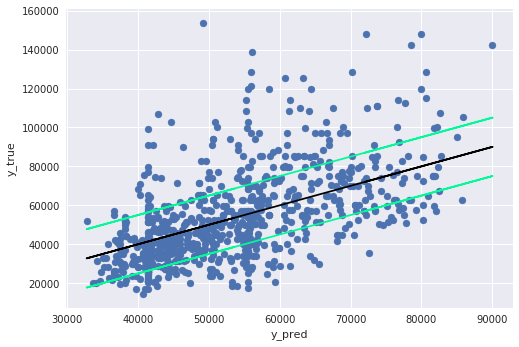

In [6]:
import matplotlib.pyplot as plt
with plt.style.context('seaborn'):
    ax = plt.scatter(y_pred,y_val)
    plt.plot(y_pred, y_pred, color='black')
    plt.plot(y_pred, y_pred-15000, color='mediumspringgreen')
    plt.plot(y_pred, y_pred+15000, color='mediumspringgreen')
    plt.xlabel('y_pred')
    plt.ylabel('y_true')